In [303]:
# dependencies
using SumOfSquares, DynamicPolynomials, SemialgebraicSets, MosekTools, SDPA
using Plots
using TaylorModels
using AffineArithmetic

In [314]:
# domains
a = Interval(-4.5, -0.3)
b = Interval(0.4, 0.9)
c = Interval(3.8, 7.8)
d = Interval(8.0, 10.0)
e = Interval(-10.0, 8.0)
f = Interval(1.0, 2.0)

REF = Dict()
RELPREC = Dict()

Dict{Any,Any} with 0 entries

In [315]:
# This function measures the relative precision of the result in a more informative way than
# taking the scalar overestimation because it evaluates the precision of the lower and the
# upper range bounds separately, see Eq. (20) in [1].
function relative_precision(x, x_ref)
    x_low, x_high = inf(x), sup(x)
    x_ref_low, x_ref_high = inf(x_ref), sup(x_ref)
    rel_low = -(x_low - x_ref_low) / (x_ref_high - x_ref_low)
    rel_high = (x_high - x_ref_high) / (x_ref_high - x_ref_low)
    return 100 * Interval(rel_low, rel_high)
end

relative_precision (generic function with 1 method)

## sine

In [316]:
model_name = "sin"
min_bound = -1.0
max_bound = sin(inf(a));
REF[model_name] = Interval(min_bound, max_bound)

[-1, 0.977531]

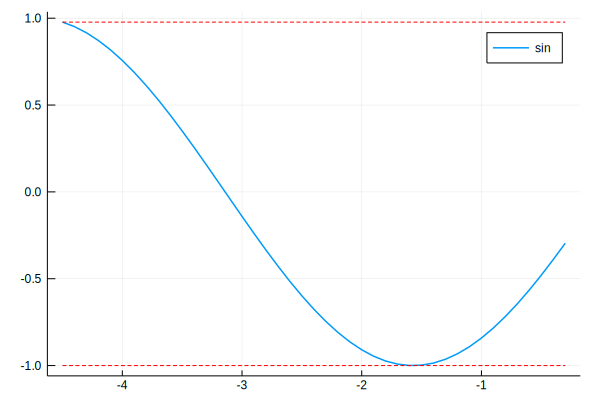

In [317]:
dom = a
plot(x -> sin(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [318]:
# using interval arithmetic substitution
@show res = sin(dom)
RELPREC[model_name, "IA"] = relative_precision(res, REF[model_name])

res = sin(dom) = [-1, 0.977531]


[-0, 5.6142e-15]

In [319]:
# using Taylor model substitution
ord = 2
x0 = Interval(mid(dom))
x = TaylorModel1(ord, x0, dom)
@show res = evaluate(sin(xord), dom - x0)
RELPREC[model_name, "TM"] = relative_precision(res, REF[model_name])

res = evaluate(sin(xord), dom - x0) = [-3.64351, 3.64351]


[133.676, 134.814]

In [320]:
# using normalized taylor model substitution
xnorm = normalize_taylor(x.pol, dom - x0, true)
xnormTM = TaylorModel1(xnorm, 0..0, 0..0, -1..1)
@show res = evaluate(sin(xnormTM), -1..1)
RELPREC[model_name, "normalized TM"] = relative_precision(res, REF[model_name])

res = evaluate(sin(xnormTM), -1 .. 1) = [-3.76749, 3.90596]


[139.946, 148.086]

In [321]:
# using affine arithmetic
x = AFF(dom, 1, 1)
@show res = interval(sin(x))
RELPREC[model_name, "AA"] = relative_precision(REF[model_name], res)

MethodError: MethodError: no method matching sin(::AFF{1,Float64})
Closest candidates are:
  sin(!Matched::Float16) at math.jl:1018
  sin(!Matched::Complex{Float16}) at math.jl:1019
  sin(!Matched::Missing) at math.jl:1070
  ...

In [322]:
RELPREC

Dict{Any,Any} with 3 entries:
  ("sin", "IA")            => [-0, 5.6142e-15]
  ("sin", "TM")            => [133.676, 134.814]
  ("sin", "normalized TM") => [139.946, 148.086]

## bspline0

In [3]:
# =============
# upper bound
# =============

model_name = "bspline0"
# model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 10
@polyvar x
p = (1 - x) * (1 - x) * (1 - x) / 6.0
dom = a
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(0.3661667079981748, 27.729158794649457)

In [4]:
MOI.get(model, MOI.SolveTime())

0.0045778751373291016

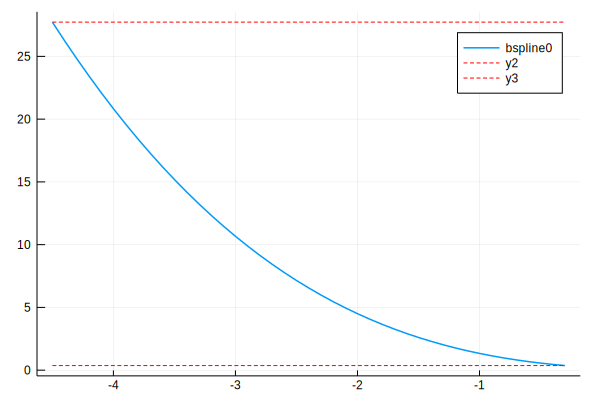

In [31]:
plot(x -> p(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)

In [52]:
a

[-4.5, -0.299999]

In [6]:
# evaluation at the extreme points
bspline0(x) = (1 - x) * (1 - x) * (1 - x) / 6.0
bspline0(sup(a)), bspline0(inf(a))

(0.36616666666666675, 27.729166666666668)

In [56]:
ord = 2
dom = a

y = TaylorModel1(ord, Interval(mid(dom)), dom)

xord = TaylorModel1(Taylor1(ord)+mid(dom), 0..0, Interval(mid(dom)), dom)
x2ord = TaylorModel1(Taylor1(2ord), 0..0, Interval(mid(dom)), dom)

 1.0 t + [0, 0]

In [63]:
evaluate(bspline0(y), dom - mid(dom))

[-14.6279, 27.7292]

In [54]:
evaluate(xord, Interval(mid(dom)))

[-2.4, -2.39999]

In [53]:
bspline0(x2ord)

 0.16666666666666666 - 0.5 t + 0.5 t² - 0.16666666666666666 t³ + [0, 0]

In [55]:
evaluate(bspline0(x), dom - mid(dom))

[-14.6279, 27.7292]

In [24]:
evaluate(bspline0(x2ord), dom - mid(dom)) # wrong on the right

[-4.63184, 4.96517]

In [22]:
evaluate(bspline0(x), dom) # wrong on the right

[-1.18184, 14.0852]

In [26]:
evaluate(bspline0(x2ord), dom) # ok

[0.366166, 27.7292]

In [30]:
evaluate(bspline0(x), dom+mid(dom)) # wrong on the left

[3.61816, 28.9652]

## bspline1

In [131]:
# =============
# upper bound
# =============

model_name = "bspline1"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 5
@polyvar x
p = (3*x*x*x - 6*x*x + 4) / 6.0
dom = a
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
model
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(-65.14582571514087, 0.5631666653631329)

In [132]:
MOI.get(model, MOI.SolveTime())

0.0020368099212646484

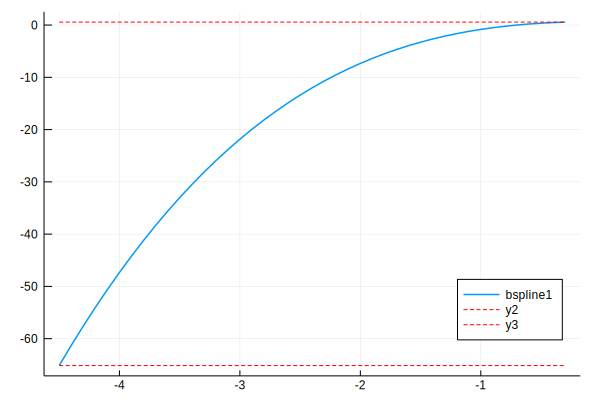

In [133]:
plot(x -> p(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)

In [177]:
# evaluation at the extreme points
bspline1(x) = (3*x*x*x - 6*x*x + 4) / 6.0
bspline1(inf(a)), bspline1(sup(a))

(-65.14583333333333, 0.5631666666666667)

In [215]:
a

[-4.5, -0.299999]

In [206]:
ord = 2
dom = a
x0 = Interval(mid(dom))
y = TaylorModel1(ord, x0, dom)

 [-2.4, -2.39999] + [1, 1] t + [0, 0]

In [207]:
evaluate(bspline1(y), dom - x0) # taylor model substitution

[-65.1459, 41.1352]

In [208]:
bspline1(dom...) # interval substitution

[-65.1459, 0.563167]

In [223]:
# normalize and evaluate
ynorm = normalize_taylor(y.pol, dom - x0, true)
ynormTM = TaylorModel1(ynorm, 0..0, 0..0, -1..1)
evaluate(bspline1(ynormTM), -1..1)    # taylor model with substitution

[-65.1459, 20.8492]

In [224]:
ynorm(-1..1), ynormTM(-1..1)

([-4.5, -0.299999], [-4.5, -0.299999])

---

In [236]:
x1 = Taylor1(2)
evaluate(normalize_taylor(bspline1(x1), dom, true), -1..1)

[-19.5834, 4.98667]

## bspline2

In [19]:
# =============
# upper bound
# =============

model_name = "bspline2"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x
p = (-3*x*x*x  + 3*x*x + 3*x + 1) / 6.0
dom = a
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(0.07407409110429998, 53.60416638772985)

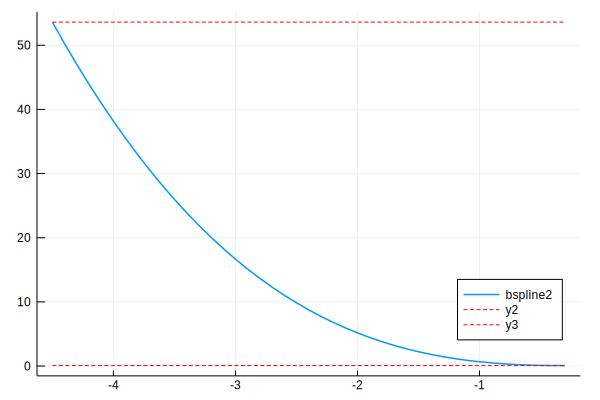

In [15]:
plot(x -> p(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)

In [17]:
# evaluation at the extreme points
bspline2(x) = (-3*x*x*x  + 3*x*x + 3*x + 1) / 6.0
bspline2(sup(a)), bspline2(inf(a))

(0.07516666666666667, 53.604166666666664)

## bspline3

In [20]:
# =============
# upper bound
# =============

model_name = "bspline3"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 5
@polyvar x
p = -x*x*x / 6.0
dom = a
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
S = @set inf(dom) <= x && x <= sup(dom)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(0.004500048981347225, 15.18749986989248)

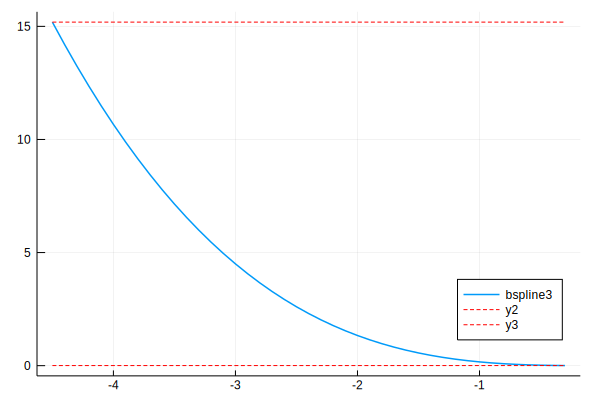

In [21]:
plot(x -> p(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash)

In [22]:
# evaluation at the extreme points
bspline3(x) = -x*x*x / 6.0
bspline3(sup(a)), bspline3(inf(a))

(0.0045, 15.1875)

## Himmilbeau

In [64]:
# =============
# upper bound
# =============

model_name = "himmilbeau"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2
p = (x1*x1 + x2 - 11)*(x1 * x1 + x2 - 11) + (x1 + x2*x2 - 7)*(x1 + x2*x2 - 7)
dom = a × b
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(85.46830677734748, 221.7338939301446)

In [66]:
ff(x1, x2) = (x1*x1 + x2 - 11)*(x1 * x1 + x2 - 11) + (x1 + x2*x2 - 7)*(x1 + x2*x2 - 7)

ff (generic function with 1 method)

In [92]:
himmilbeau(x1, x2) = (x1*x1 + x2 - 11)*(x1 * x1 + x2 - 11) + (x1 + x2*x2 - 7)*(x1 + x2*x2 - 7)

dom = a×b
ord = 2
numvars = 2

set_variables(Float64, "x", order=2ord, numvars=2)
x = [TaylorModelN(i, ord, IntervalBox(mid(dom)), dom) for i=1:numvars]

evaluate(himmilbeau(vars...), dom-mid(dom)) # this is Taylor model evaluation

[-57.3385, 344.697]

In [98]:
himmilbeau(dom...) # this is an Interval evaluation

[-64.5565, 239.056]

In [99]:
# normalized Taylor model


In [ ]:
# ======================
# Normalization
# ======================
symmetric_domain(dom::Interval) = Interval(-1, 1)
symmetric_domain(dom::IntervalBox) = IntervalBox(-1..1, length(dom))

# Helper function to evaluate after normalization
function normalize_and_evaluate(p, dom)
    dom_sym = symmetric_domain(dom)
    evaluate(normalize_taylor(p, dom, true), dom_sym)
end

In [130]:
bspline1()

UndefVarError: UndefVarError: bspline1 not defined

In [125]:
dom = Interval(0, pi/2)
x0 = Interval(mid(dom))
y = TaylorModel1(2, x0, dom)
tm = sin(y)
evaluate(tm, dom - x0) # taylor model substitution

[-0.110721, 1.5469]

In [126]:
sin(dom) # interval substitution

[0, 1]

In [127]:
ynorm = normalize_taylor(y.pol, dom - x0, true)
tmnorm = sin(TaylorModel1(ynorm, 0..0, 0..0, -1..1))

 [0.707106, 0.707107] + [0.55536, 0.555361] t + [-0.21809, -0.218089] t² + [-0.0443777, 0.0663431]

In [129]:
evaluate(tmnorm, -1..1)

[-0.110721, 1.32882]

## Kepler1

In [92]:
# =============
# upper bound
# =============

model_name = "kepler1"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2 x3 x4 x5 x6
p = x2 * x5 + x3 * x6 - x2 * x3 - x5 * x6 + x1 * (-x1 + x2 + x3 - x4 + x5 + x6)
dom = a × b × c × d × e × f
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b) &&
         inf(c) <= x3 && x3 <= sup(c) &&
         inf(d) <= x4 && x4 <= sup(d) &&
         inf(e) <= x5 && x5 <= sup(e) &&
         inf(f) <= x6 && x6 <= sup(f)

@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(-5.255935494810441, 7.321362422825775)

## Kepler2

In [94]:
# =============
# upper bound
# =============

model_name = "kepler2"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2 x3 x4
p = x1 * x4 * (-x1 + x2 + x3 - x4) + x2 * (x1 - x2 + x3 + x4) +
    x3 * (x1 + x2 - x3 + x4) -x2 * x3 * x4 - x1 * x3 - x1 * x2 - x4
dom = a × b × c × d
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b) &&
         inf(c) <= x3 && x3 <= sup(c) &&
         inf(d) <= x4 && x4 <= sup(d)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(-195.36974909125482, 78.3669520644375)

## Kepler3

In [95]:
# =============
# upper bound
# =============

model_name = "kepler3"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2 x3 x4 x5 x6
p =  x1 * x4 * (-x1 + x2 + x3 - x4 + x5 + x6) +
     x2 * x5 * (x1 - x2 + x3 + x4 - x5 + x6) +x3* x6 * (x1 + x2 - x3 + x4 + x5 - x6) -
     x2 * x3 * x4 -x1* x3* x5 - x1 * x2 * x6 - x4 * x5 * x6
dom = a × b × c × d × e × f
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b) &&
         inf(c) <= x3 && x3 <= sup(c) &&
         inf(d) <= x4 && x4 <= sup(d) &&
         inf(e) <= x5 && x5 <= sup(e) &&
         inf(f) <= x6 && x6 <= sup(f)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(-309.8484155131222, 17.982082401462407)

## RigidBody1

In [97]:
# =============
# upper bound
# =============

model_name = "rigidbody1"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2 x3
p = -x1*x2 - 2*x2*x3 - x1 - x3
dom = a × b × c
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b) &&
         inf(c) <= x3 && x3 <= sup(c)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(-20.786552979420335, -0.540012836551535)

## RigidBody2

In [98]:
# =============
# upper bound
# =============

model_name = "rigidbody2"
#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
k = 6
@polyvar x1 x2 x3
p = 2*(x1*x2*x3) + (3*x3*x3) - x2*(x1*x2*x3) + (3*x3*x3) - x2
dom = a × b × c
@variable(model, γ)
S = @set inf(a) <= x1 && x1 <= sup(a) &&
         inf(b) <= x2 && x2 <= sup(b) &&
         inf(c) <= x3 && x3 <= sup(c)
@constraint(model, p <= γ, domain=S, maxdegree=k)
@objective(model, Min, γ)
optimize!(model)
max_bound = objective_value(model)

# =============
# lower bound
# =============

#model = SOSModel(with_optimizer(SDPA.Optimizer))
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(model, γ)
@constraint(model, p >= γ, domain=S, maxdegree=k)
@objective(model, Max, γ)
optimize!(model)
min_bound = objective_value(model)
REF[model_name] = (min_bound, max_bound)

(68.81138021006673, 359.98566570476504)

## Results

In [115]:
[println(string(k), " : ", REF[k]) for k in keys(REF)];

bspline1 : (-65.14582571514087, 0.5631666653631329)
himmilbeau : (85.46830677734748, 221.7338939301446)
bspline3 : (0.004500048981347225, 15.18749986989248)
rigidbody1 : (-20.786552979420335, -0.540012836551535)
rigidbody2 : (68.81138021006673, 359.98566570476504)
bspline2 : (0.07407407744904644, 53.60416654726812)
kepler1 : (-5.255935494810441, 7.321362422825775)
bspline0 : (0.36616666317087393, 27.729165285894855)
kepler3 : (-309.8484155131222, 17.982082401462407)
kepler2 : (-195.36974909125482, 78.3669520644375)
